# Build (a Danish) Sentiment Model in Less Than 30 minutes

### Journey Behind: Hair-cut Problem

![alt text](../images/afro.PNG)

[Dribble: richamond](https://dribbble.com/places/richmond)

### Long Process

![alt text](../images/trans.GIF)

### ROI

![alt text](../images/costy.PNG)

[Dribble: parhawn]( https://dribbble.com/parhawm)

## Business Value Defines Everything

![alt text](../images/business.PNG)

## Simple Flow

![alt text](../images/simple.PNG)

## Usage Examples

![alt text](../images/example.PNG)

# Demo: Sanic and Tableau


## Definitions

![alt text](../images/definition.PNG)

## Show me the code

### Let the timedown begin

In [2]:
time_start = pd.datetime.now()

import re               # pattern matching
import requests         # getting data from web

import pandas as pd
import numpy as np

import collections      # Counting made easy

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf

### Get our data

#### Historical Data
- Theory: We use different bag of words when writing a positive/negative reviews
- If we train a supervised model with positive/negative labels, we can capture future bag of words sentiment 
- Gather data with positive/negative reviews

##### This model uses TrustPilot Public Reviews Data. 
     Has nothing to do with If and thus can be shared under education license.

##### For company specific model, Customer Satisfication(CX) feedback, can be used to do the same.

### Explore our data

In [7]:
df.sample(5) #.head() and .tail()

datePublished             headline inLanguage  ratingValue  \
1774   2016-06-21 18:19:44    Gode forsikringer         da            4   
677549 2018-03-02 14:49:44      Hurtig levering         da            5   
119040 2017-06-09 04:19:08  afhentning af pakke         da            5   
656408 2018-05-05 17:44:46            Effektivt         da            5   
687637 2018-02-04 16:50:14       Hurtig service         da            5   

                                               reviewBody       reviewerName  
1774    Vi havde en god oplevelse med besøg fra If. Vi...              Janni  
677549                                    Hurtig levering     dorthe  Larsen  
119040  Super fin betjening meget nemt, når man modtag...  Jette Christensen  
656408  Bestilte kl 18 aftenen før og kunne hente dage...            Jesper   
687637  Jeg kunne hente pakken i pakkeshoppen dagen ef...            Tanja L

#### randomaize data, set seed for reproducibility, make a copy

In [10]:
np.random.seed(7)
data = df.reindex(np.random.permutation(df.index))

#### double check to see if data contains our language of choice. if not, do something about it
e.g. data = data[(data['inLanguage']=='da')]

In [11]:
data['inLanguage'].unique()

array(['da'], dtype=object)

Keep on the columns that we are after reviews and their ratings

In [12]:
data = data[['reviewBody','ratingValue']]
# or this:
# data.drop(columns=['headline','datePublished','inLanguage','reviewerName'], inplace=True)

Change column names to something more DS (Absolutely unnecessary)

In [13]:
data.rename(columns={'reviewBody':'features','ratingValue':'target'}, inplace=True)

In [14]:
data.iloc[10:15]

features  target
405284  Altid fremragende service hos post.dk, min sæd...       5
441451  Jeg blev ringet op af en sælger, der solgte mi...       2
63283                  God servise, aflevering til tiden.       4
179442  Fik sms besked og mail fra morgenstunden på at...       3
287829  Pakke omdelt og afleveret selvom jeg med vilje...       3

#### Let's check if there are nulls 
if there are null, drop them. You can use data.dropna(axis=0, how='any', inplace=True) # axis=0 row =1 columns <br/>
**Tip:** _data.isnull().sum().sum()_ returns groupped null count

##### Check if we have empty or 1 length features

#### ...

#### Data Cleaning

### EDA 
    Exploratory Data Analysis is an art of analyzing data set to summarize its main characteristics.
    It is the heart of  understanding your data and building methods to solve your porble

{5: 373381, 4: 87146, 1: 84882, 2: 42350, 3: 40490} 



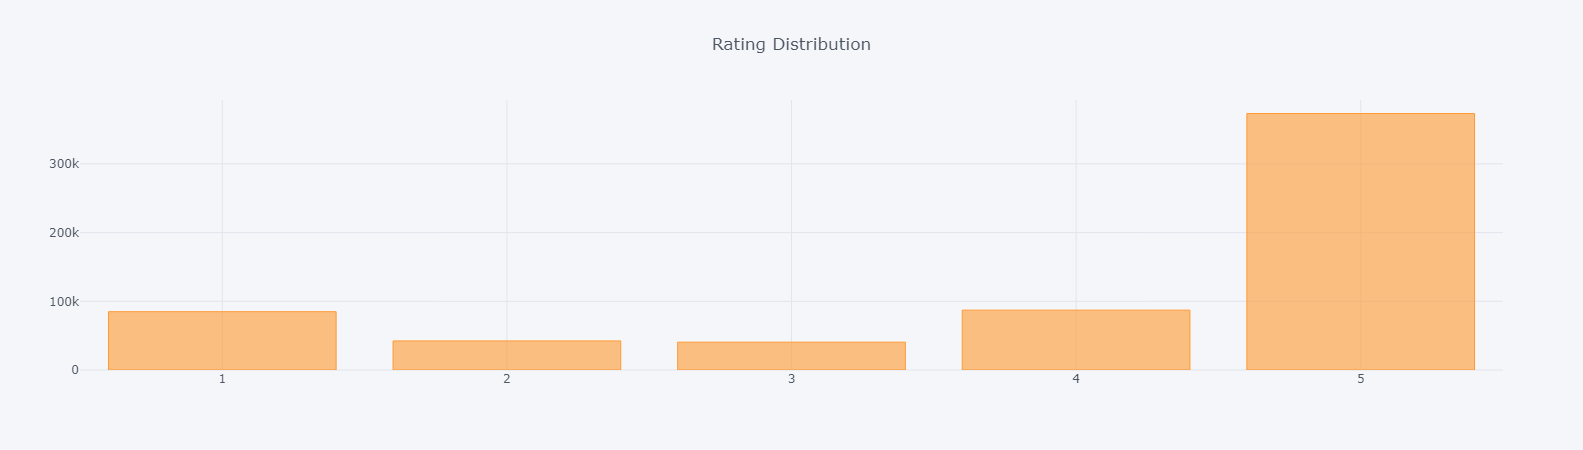

In [18]:
print(data['target'].value_counts().to_dict(),'\n')
_ = data['target'].value_counts().iplot(kind='bar', title='Rating Distribution')

## Let's make a binary problem. From 5 possible targets to 2
    Middle valued comments can fall in either side. To avoid this problem, I just dropped them 

In [24]:
# Lets  drop rating of 3, and group 1-2 as 0, and 4-5 as 1
data.drop(data[~(data['target']!=3)].index, inplace=True) #or data= data[(data['target'] !=3)]
data['y'] = np.where(data['target']>3,1,0)

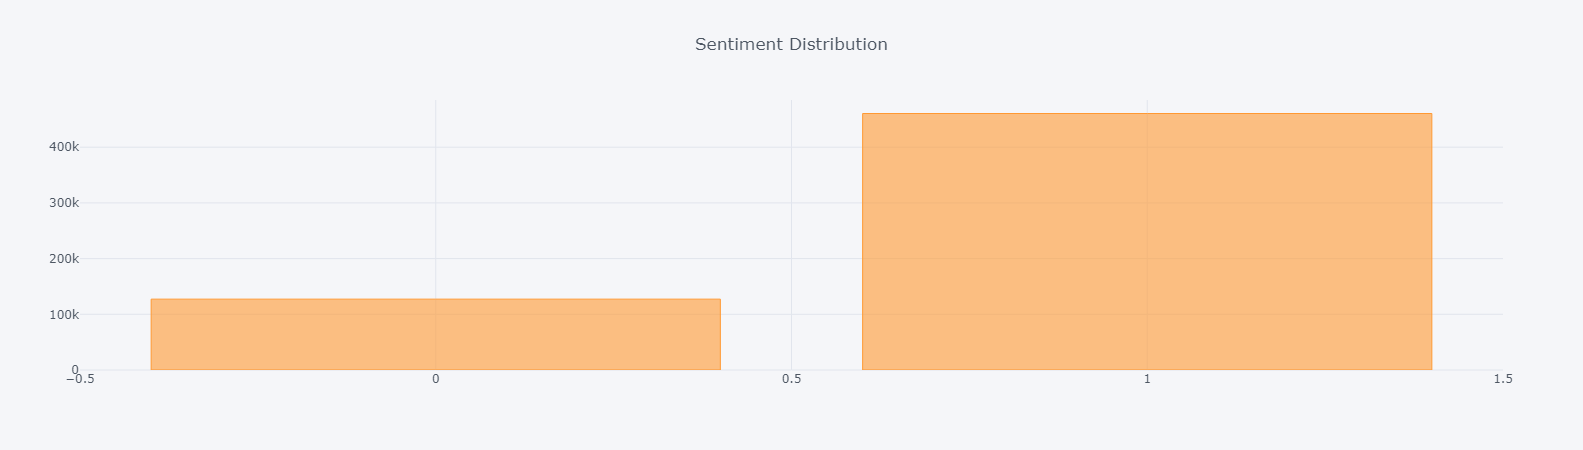

In [25]:
# print(data['y'].value_counts().to_dict(),'\n')
_ = data['y'].value_counts().iplot(kind='bar', title='Sentiment Distribution');

## We can see that we have unbalanced data: 
    1. This tells us that we have to undersample 1, 
    2 .or use class weight
    3. or use algorithms that are not unbalanced data sensitive
    

### How are words used in positive | negative rated reviews
 use a helper function :) https://gist.github.com/Proteusiq/85f9d1131f8256e05234fd57c564d2e9

In [26]:
def terms_frequency(corpus, words_only=False,emoji_only=False, emoji_normalize=False):
    
    '''
    Takes in texts and returns a pandas DataFrame of words frequency
    words_only=True if only words needed
    emoji_only=True if only emoji_only. emoji_nomalize removes noses and turn ; to :
    requirement = pandas
    '''
    corpus_ = corpus.lower()
    # eyes [nose] mouth | mouth [nose] eyes pattern
    emoticons = r"(?:[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?)"
    emoticon_re = re.compile(emoticons, re.VERBOSE | re.I | re.UNICODE)
    
    if words_only:
        terms = (re.sub('[\W]+', ' ', corpus_)).split()
    
    elif emoji_only:
        terms = re.findall(emoticon_re, corpus_)
    
    else:
        if emoji_normalize:
            normalize_str = (re.sub('[\W]+', ' ', corpus.lower()) +
                                  ' '.join(re.findall(emoticon_re, corpus)).replace(';',':').replace('-',''))
            terms = normalize_str.split()
        else:
            terms = (re.sub('[\W]+', ' ', corpus_).split())
            terms.extend(re.findall(emoticon_re, corpus_))
                                                        
    
    terms_freq = pd.DataFrame.from_dict(collections.Counter(terms), orient='index').reset_index()

    terms_freq = terms_freq.rename(columns={'index':'word', 0:'count'}).sort_values('count',ascending=False)
                
    terms_freq.reset_index(inplace=True)
    terms_freq.drop('index',axis=1,inplace=True)
                                                             
    return terms_freq

In [30]:
pos_df.head(10)

word   count
0        og  156771
1    hurtig  101410
2  levering   92389
3       jeg   69278
4       det   56307
5       til   51362
6       god   51135
7        at   49428
8        er   49089
9        en   46082

In [31]:
neg_df.loc[:10,]

word  count
0     jeg  42496
1      at  32809
2      en  29912
3       i  26268
4      er  22610
5     har  21584
6   pakke  19141
7    ikke  18077
8      og  18017
9     til  17173
10    det  16782

## Oh! Something Fishy
It appears that we have a problem. There is noise in our data. Words that does not add any meaningful indicator towards sentiments.
Lets explore them and find a solution.

In [32]:
pos_neg_df = pos_df.merge(neg_df.drop_duplicates(), on=['word'], 
                   how='left', indicator=True)

neg_pos_df = neg_df.merge(pos_df.drop_duplicates(), on=['word'], 
                   how='left', indicator=True)

In [33]:
pos_neg_df.head()

word  count_x  count_y _merge
0        og   156771  18017.0   both
1    hurtig   101410    738.0   both
2  levering    92389   4607.0   both
3       jeg    69278  42496.0   both
4       det    56307  16782.0   both

In [35]:
p_data, n_data = pos_neg_df[(pos_neg_df['_merge']=='both')],  neg_pos_df[(neg_pos_df['_merge']=='both')]

In [36]:
fig = {
    'data': [
        {
        'x': p_data.count_x, 
            'y': p_data.count_y, 
            'text': p_data.word, 
            'mode': 'markers', 
            'name': 'Positive'},
  {
           'x': n_data.count_x, 
           'y': n_data.count_y, 
            'text': n_data.word, 
            'mode': 'markers', 
            'name': 'Negative'},
    ],
    'layout': {
        'xaxis': {'title': 'Postive Words Count'},
        'yaxis': {'title': "Negative Words Count"}
    }
}

## Visualize our problem

### Positive & Negative with Stop-words

In [37]:
py.iplot(fig)

#### Positive With Stop-words

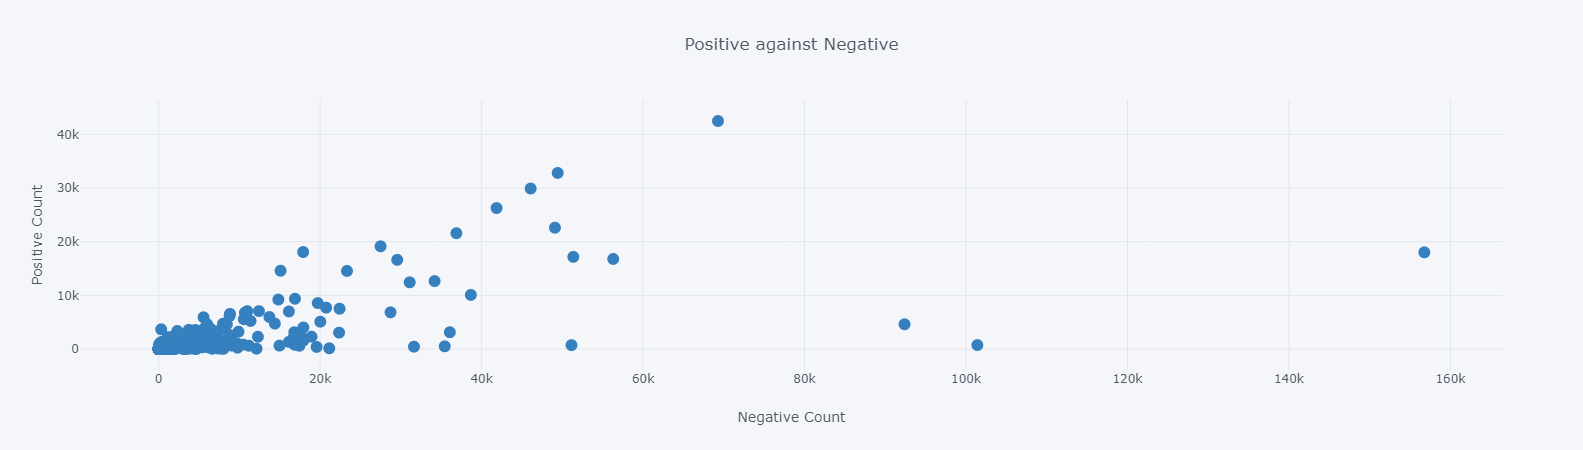

In [38]:
p_data.iplot(kind='scatter', mode='markers', x='count_x', y='count_y',
             text='word', color='blue', title='Positive against Negative', 
             yTitle='Positive Count', xTitle='Negative Count',filename='cufflinks/simple-scatter')

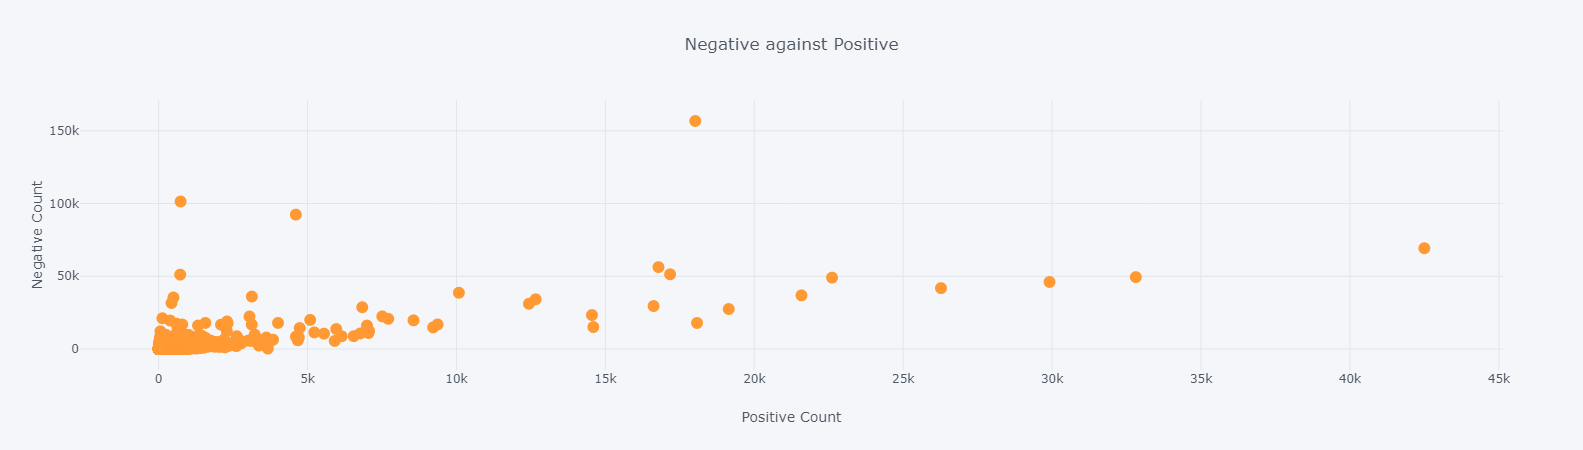

In [39]:
n_data.iplot(kind='scatter', mode='markers', x='count_x', y='count_y',
             text='word', title='Negative against Positive', 
             yTitle='Negative Count', xTitle='Positive Count',filename='cufflinks/simple-scatter')

### Lets remove these words

[Stopwords ISO](https://github.com/stopwords-iso) maintained by Gene Diaz contains
one of most comprehensive collection of multiple languages stopwords

In [40]:
# Using requests to gather data directly as json

url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-da/master/stopwords-da.json'
r = requests.get(url) # for large files use stream=True

if r.ok:
    stop_words = set(r.json())

In [41]:
stops = stop_words - set(['aldrig','god','godt','ikke','ingen','intet']) # from what we know, we will keep this

# With background knowledge of our data, namely reviews coming from TrustPilot, we know that some of the words are of no use to us.

# We can remove them one by one, as an example of how not to do this ..:)
stops = stops.union(set(['hjemme','hilsen','service','pakken','pakke','pakker','sms','post','bestil','bestilte','bestilt',
                         'levering','postnord','kr','kl','levered','leveret','gang','gange','mail',
                         'besked','dag','dage','ring','alm brand','dansk bank'])) # all kind of ring?

In [42]:
# Better way is to use regex and the power of pandas str function
# Pandas allows us to do so much more. e.g. We can remove words in using regex, str.contains
#e.g. remove all words that starts with ring and end with anythin words from 0 to 2 letters.

ring_words = neg_df[neg_df['word'].str.contains('^ring\w{,2}$',regex=True)]['word'].values.tolist()

In [43]:
# Even better, chain multiple regex. The sky is the limit.
comb_words = pos_df[pos_df['word'].str.contains('^pakk|^post|^lever|^bestil|^trac|^dage',regex=True)]['word'].values.tolist()

In [44]:
# Using set has two advantages. Sets holds only unique values, and it is faster than list or dictionary in this case 
stops = stops.union(set(ring_words+comb_words))

In [45]:
# We can look at the stop words in our positive sentiment data as follows
_ = pos_df.set_index('word').loc[stops].sort_values('count', ascending=False)
_.head(5)

count
word              
og        156771.0
levering   92389.0
jeg        69278.0
det        56307.0
til        51362.0

In [48]:
neg_df = tune_df(neg_df)
pos_df = tune_df(pos_df)

In [49]:
pos_neg_df = pos_df.merge(neg_df.drop_duplicates(), on=['word'], 
                   how='left', indicator=True)

neg_pos_df = neg_df.merge(pos_df.drop_duplicates(), on=['word'], 
                   how='left', indicator=True)

### Removed Stop-words. Not fishy anymore :)

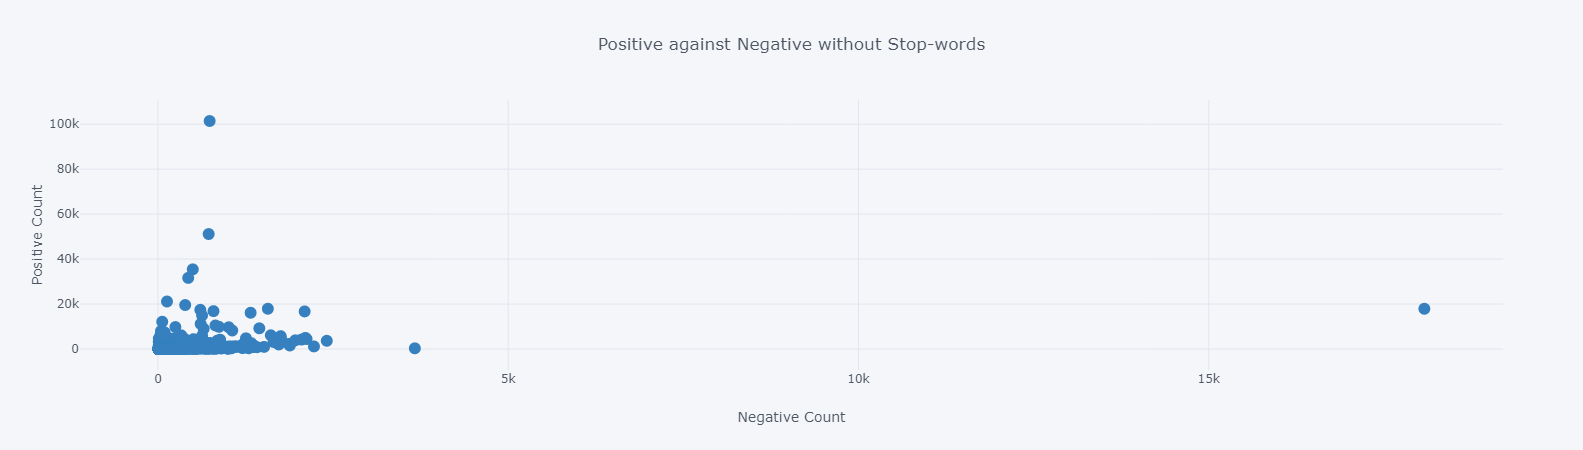

In [50]:
pos_neg_df.iplot(kind='scatter', mode='markers', y='count_x', x='count_y',
             text='word', color='blue', title='Positive against Negative without Stop-words', 
             yTitle='Positive Count', xTitle='Negative Count',filename='cufflinks/simple-scatter')

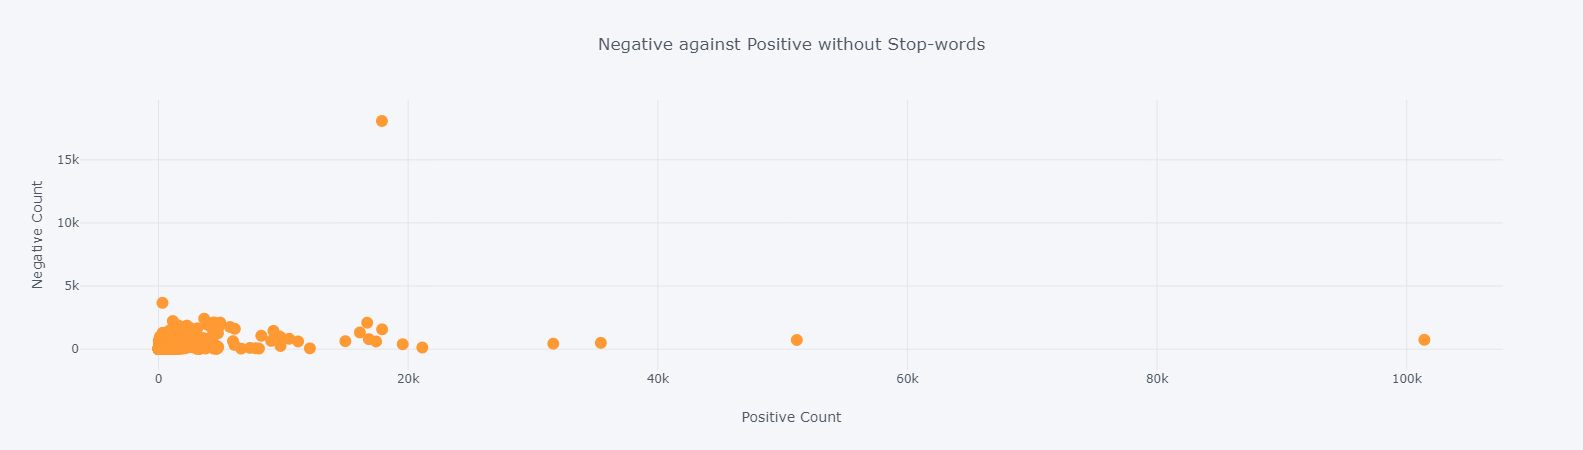

In [51]:
neg_pos_df.iplot(kind='scatter', mode='markers', y='count_x', x='count_y',
             text='word', title='Negative against Positive without Stop-words', 
             yTitle='Negative Count', xTitle='Positive Count',filename='cufflinks/simple-scatter')

## Three Ways of Building Sentiment Models (Possibly More!)
- [ ] Lexicon Way
- [x] Machine Learning Way
- [ ] Both Ways

### AFINN by [Finn Årup Nielsen (DTU)](https://github.com/fnielsen) 

##### [afinn](https://github.com/fnielsen/afinn) is Finn's giant contribution to NLP  
The basic idea is to score words in a sentince with their predefined scores

### Nuggets from [Ken Benoit's](http://www.kenbenoit.net/cv/publications/) papers on Lexicon Scoring

Absolute Proportional Difference. Bounds: [0,1]

Sentiment = (P − N) / N

Disadvantage: A sentence's score is affected by non-sentiment-related content.

Relative Proportional Difference. Bounds: [-1, 1]

Sentiment = (P − N) / (P + N)

Disadvantage: A sentence's score may tend to cluster very strongly near the scale endpoints (because they may contain content primarily or exclusively of either positive or negative).

Logit scale. Bounds: [-infinity, +infinity]

Sentiment = log(P + 0.5) - log(N + 0.5)

This tends to have the smoothest properties and is symmetric around zero. The 0.5 is a smoother to prevent log(0). 

In [52]:
url = 'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/'
url_words = 'AFINN-da-32.txt'
url_emoji = 'AFINN-emoticon-8.txt'

scored_words = pd.read_csv(url+url_words,sep='\t', names = ['ord','score'])
scored_emoji = pd.read_csv(url+url_emoji,sep='\t', names = ['ord','score'])


In [53]:
scored_words.sample(10)

ord  score
711     forbedrer      2
43     afskyeligt     -3
1886   modstander     -2
936     fremdrift      2
862   forskrækket     -2
2512        skyde     -1
2032         omhu      2
3238         utak     -2
1512    kompetent      2
34        aflyste     -2

In [54]:
scored_emoji.sample(5)

ord  score
35         ;)      2
23        :-/     -2
95   xoxoxoxo      4
10        :-)      2
61  :))))))))      4

In [55]:
# Lets append scored_emojis. I know, I know, I should not use the same scored_words :) but I have :/. Bit me!
scored_words = scored_words.append(scored_emoji, ignore_index=True)

In [56]:
# Lets test a simple scoring ...

sentence = 'jeg hader ms excel :('
a = [sum(scored_words.loc[scored_words['ord'].isin([word]),'score']) for word in sentence.split() if word in scored_words.values]
a

[-3, -2]

In [57]:
# What did we fish in Finn's pool of scored words

scored_words[(scored_words['ord'] == 'hader')|(scored_words['ord'] == ':(')]

ord  score
1142  hader     -3
3553     :(     -2

## We can test how good such models are.

##### Tokenize sentences, then apply our basic Lexicon function
Tokenize? What is that creature? Worry not, we will touch that in a bit. In short, it is all about chopping sentences to small chunks. 

### With that said, lets test our simple lexicon scoring model

In [67]:
token_kwargs = dict(emoji_normalize=True,remove_digits=True,
                        lower_case=True,stop_words=stops)

In [68]:
def sentiment_score(sentence):
    '''
    Relative Weighted Proportional Difference'
    returns weighted sentiment
    '''
    a = [sum(scored_words.loc[scored_words['ord'].isin([word]),'score']) for word in token(sentence,**token_kwargs) if word in scored_words.values]
    AP = sum(x for x in a if x > 0)
    AN = sum(x for x in a if x < 0)
    
    return (AP - abs(AN))/(AP + abs(AN)) if (AP + abs(AN)) !=0 else 1

In [72]:

def avg_accuracy(model_score, k=100, nsample=50):
    '''
    Get mean scores of our simple lexicon scoring
    '''
    
    np.random.seed(42)
    avg_score = list()
    for i in range(1,k+1):
        print(f'{i}', end=' ')
        pos_data = pos.sample(nsample)
        neg_data = neg.sample(nsample)

        test_data = pos_data.append(neg_data, ignore_index=True)['features y'.split()]
        
        test_data['sentiment'] = test_data['features'].map(model_score)
        test_data['y_pred'] = test_data['sentiment'].apply(lambda x: 1 if x >0 else 0) 
        
        avg_score.append(np.mean(test_data['y']==test_data['y_pred']))
    avg_score = np.array(avg_score)
    print(f"\nMean Scored: {avg_score.mean():.1%}\n\tStd: {avg_score.std():.3f}")

In [73]:
%%time
avg_accuracy(sentiment_score,k=15)   

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Mean Scored: 71.4%
	Std: 0.030
CPU times: user 24.8 s, sys: 156 ms, total: 24.9 s
Wall time: 25.7 s


In [74]:
from afinn import Afinn

In [75]:
afinn = Afinn(language='da', emoticons=True)

In [76]:
def lex_score(sent):
    return 1 if afinn.score(sent) > 0 else 0

In [77]:
%%time
avg_accuracy(lex_score,k=15)   

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Mean Scored: 70.1%
	Std: 0.039
CPU times: user 3.55 s, sys: 15.6 ms, total: 3.56 s
Wall time: 3.68 s


### Impressive results! ah!
I think it is impressive given that this is a very basic lexicon scoring, made in less than 5 minutes<br>
Finn's model is way complex and much better. <br>
<br>
**This raises some questions:**
* Why use Machine Learning, if simple lexicon scoring works? 
* Can Machine learning do better?
* How about combaining the two?

Lexicon scoring has clear limitations.<br\>
1. It won't catch negations. e.g. _der er ikke dårlig_(en: _it is not bad_)
2. New words, such as slangs, might be missed, unless the lexicon is frequently updated.

Yes, Machine Learning is way better.<br\>
And well, Machine Learning is the new boy in town :)<br\>

Combaining the two would definitely be something to try. I have not. I am not sure I will :)

## Test ML Model
## Run model as a service

In [78]:
import requests, json
url = 'http://localhost:8000/score'
header = {'Content-type':'application/json'}
def ml_score(sent):
    data = {'data':sent}
    response = requests.post(url, data=json.dumps({'data':sent})).json()['results']['positive']
    return 1 if response > .5 else 0

In [79]:
%%time
avg_accuracy(ml_score,k=15)      
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Mean Scored: 92.2%
	Std: 0.019
CPU times: user 7.34 s, sys: 3.33 s, total: 10.7 s
Wall time: 28.2 s


### Get some powers with ML
##### A Very Short Introduction 

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer,
                                             TfidfTransformer)

In [81]:
# Words in Context
# Before we only look at unigrams. We could advance our methods with n-grams e.g. 2-3 words
ct_para = dict(analyzer='word',stop_words=stops, 
                 tokenizer=token, ngram_range=(2, 3), min_df=10)

def count_words(feature):
    
    ct = CountVectorizer(**ct_para)
    print('counting words ...')
    words = ct.fit_transform(feature)
    print('Words counted')
    words.sum(axis=0).A1
    
    words = collections.Counter(dict(zip(list(ct.get_feature_names()),words.sum(axis=0).A1 )))
    

    n_grams = collections.OrderedDict(words.most_common())
    n_grams_df = pd.DataFrame.from_dict(n_grams, orient='index').reset_index()
    
    return n_grams_df.rename(columns={'index':'n_grams', 0:'count'})

In [82]:
%%time
n_grams_pos_df = count_words(pos['features'])

counting words ...
Words counted
CPU times: user 1min, sys: 7.05 s, total: 1min 7s
Wall time: 1min 10s


In [83]:
n_grams_pos_df.iloc[10:15]

n_grams  count
10        super god   4094
11       fin hurtig   3805
12  hurtig effektiv   3748
13  god information   3538
14       hele vejen   3395

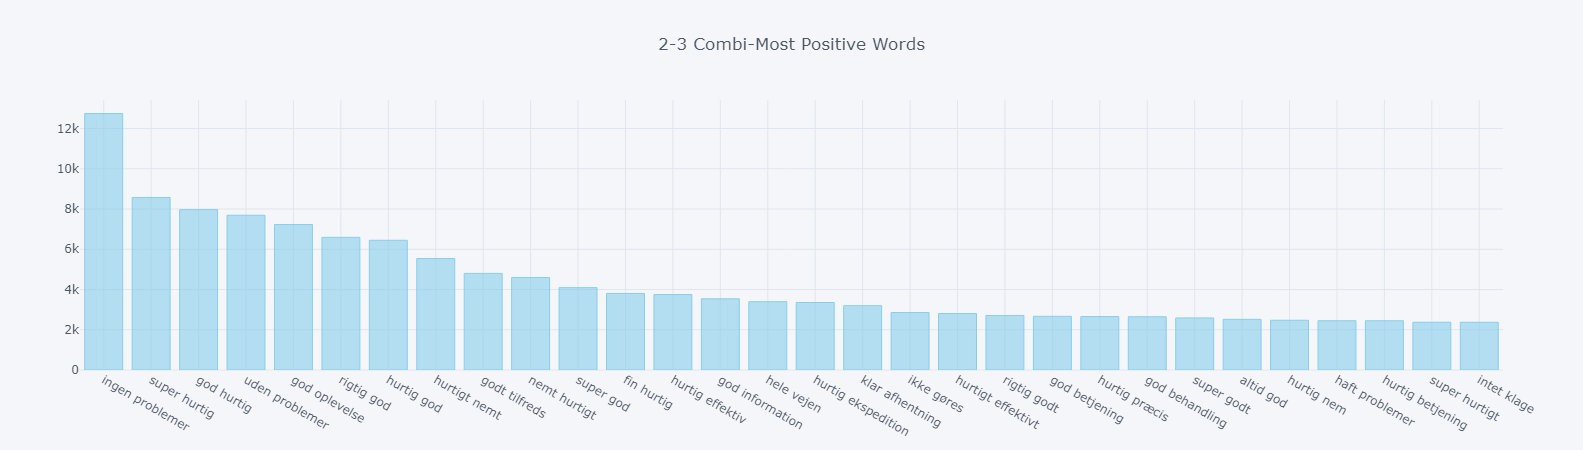

In [84]:
g = n_grams_pos_df.iloc[:30].iplot(kind='bar', x='n_grams', y='count', color='skyblue', title='2-3 Combi-Most Positive Words')

In [85]:
%%time
n_grams_neg_df = count_words(neg['features'])

counting words ...
Words counted
CPU times: user 1min 10s, sys: 12.4 s, total: 1min 22s
Wall time: 1min 23s


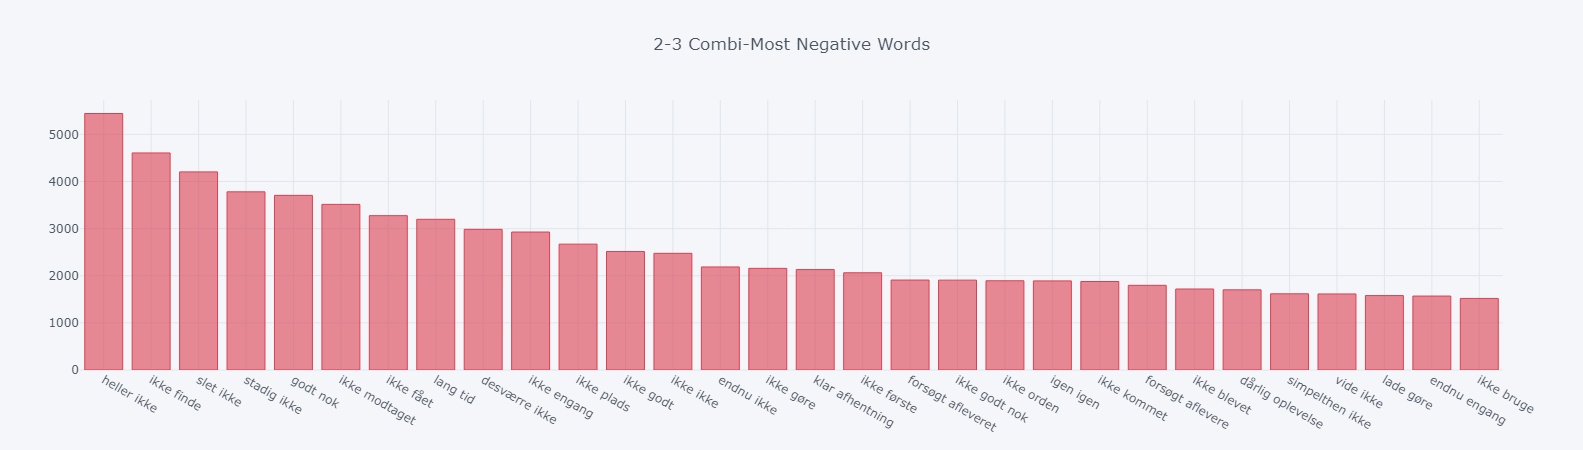

In [86]:
g = n_grams_neg_df.iloc[:30].iplot(kind='bar', x='n_grams', y='count', color='red', title='2-3 Combi-Most Negative Words')

### Understanding CountVectorizer and TfidfVectorizer

sublinear_df is set to True to use a logarithmic form for frequency.<br>
min_df is the minimum numbers of documents a word must be present in to be kept.<br>
norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.<br>
ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.

In [91]:
#%%time

dum_data = [('Vi elsker 23 dansk øl og pizza','pizza'),('dominos pizza er den bedste :) ','pizza'),
            ('python, øl og pizza i huset','pizza'),('lad os drikke øl, ja! :) øl og kode i python','python'),
            ('python :) er det smukkeste programmeringssprog','python')]
labels = ['features','tags']

dum_data_df = pd.DataFrame.from_records(dum_data, columns=labels)

In [92]:
dum_data_df

features    tags
0                  Vi elsker 23 dansk øl og pizza   pizza
1                 dominos pizza er den bedste :)    pizza
2                     python, øl og pizza i huset   pizza
3    lad os drikke øl, ja! :) øl og kode i python  python
4  python :) er det smukkeste programmeringssprog  python

In [93]:
word_vec = Pipeline(steps = [
                 ('dk_clean', DanishCleaner(remove_digits=True, lower_case=True, emoji_normalize=True)),
                ('word_vec', CountVectorizer(tokenizer=token, stop_words=stops,min_df=1))
            ])

In [94]:
fitted_word_vec = word_vec.fit_transform(dum_data_df['features'])

In [95]:
word_vec.steps[1][1].get_feature_names()

[':)',
 'bedste',
 'dansk',
 'dominos',
 'drikke',
 'elsker',
 'huset',
 'kode',
 'pizza',
 'programmeringssprog',
 'python',
 'smukkeste',
 'øl']

In [96]:
dum_data_df

features    tags
0                  Vi elsker 23 dansk øl og pizza   pizza
1                 dominos pizza er den bedste :)    pizza
2                     python, øl og pizza i huset   pizza
3    lad os drikke øl, ja! :) øl og kode i python  python
4  python :) er det smukkeste programmeringssprog  python

In [97]:
dum_data_df_vec = pd.DataFrame(fitted_word_vec.toarray(), columns=word_vec.steps[1][1].get_feature_names())
dum_data_df_vec

:)  bedste  dansk  dominos  drikke  elsker  huset  kode  pizza  \
0   0       0      1        0       0       1      0     0      1   
1   1       1      0        1       0       0      0     0      1   
2   0       0      0        0       0       0      1     0      1   
3   1       0      0        0       1       0      0     1      0   
4   1       0      0        0       0       0      0     0      0   

   programmeringssprog  python  smukkeste  øl  
0                    0       0          0   1  
1                    0       0          0   0  
2                    0       1          0   1  
3                    0       1          0   2  
4                    1       1          1   0

In [98]:
tfdif_para = dict(tokenizer=token, sublinear_tf=True, min_df=1, norm='l2', #encoding='latin-1', 
            ngram_range=(1, 1), stop_words=stops)

In [99]:
word_tfdif = Pipeline(steps = [
                 ('dk_clean', DanishCleaner(remove_digits=True, lower_case=True)),
                ('word_tdf',  TfidfVectorizer(**tfdif_para))
            ])

In [100]:
%%time

fitted_tfdif = word_tfdif.fit_transform(dum_data_df['features'])

CPU times: user 31.2 ms, sys: 15.6 ms, total: 46.9 ms
Wall time: 37.2 ms


In [101]:
tfdif_features, labels = fitted_tfdif.toarray(), dum_data_df['tags']

In [102]:
pd.DataFrame(tfdif_features, columns=word_tfdif.steps[1][1].get_feature_names())

:)    bedste     dansk   dominos    drikke    elsker     huset  \
0  0.000000  0.000000  0.587521  0.000000  0.000000  0.587521  0.000000   
1  0.393470  0.587521  0.000000  0.587521  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.652948   
3  0.327457  0.000000  0.000000  0.000000  0.488952  0.000000  0.000000   
4  0.393470  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

       kode     pizza  programmeringssprog    python  smukkeste        øl  
0  0.000000  0.393470             0.000000  0.000000   0.000000  0.393470  
1  0.000000  0.393470             0.000000  0.000000   0.000000  0.000000  
2  0.000000  0.437287             0.000000  0.437287   0.000000  0.437287  
3  0.488952  0.000000             0.000000  0.327457   0.000000  0.554433  
4  0.000000  0.000000             0.587521  0.393470   0.587521  0.000000

In [103]:
from sklearn.linear_model import LogisticRegression

In [104]:
word_vec_para = dict(ngram_range=(1, 2),tokenizer=token,
                     lowercase=True,stop_words=stops,min_df=1)

In [105]:
simple_model = Pipeline(steps = [
                 ('dk_clean', DanishCleaner(remove_digits=True, lower_case=True)),           
                ('word_vec', CountVectorizer(**word_vec_para)),
                ('word_tdf',  TfidfTransformer(sublinear_tf=True)),
                ('fe_se', SelectKBest(chi2, k='all')),
                ('log_reg',LogisticRegression(verbose=1))
            ])

In [106]:
_ = simple_model.fit(dum_data_df['features'],dum_data_df['tags'])

[LibLinear]

In [107]:
simple_model.predict(dum_data_df['features'])

array(['pizza', 'pizza', 'pizza', 'python', 'python'], dtype=object)

In [108]:
d_data = [('Hvem elsker ikke Pizza?',),('Der findes en rigtigt meget om Python programmeringssprog på engelsk',),
            ('Hvis man går efter autentisk pizza, så skal man bruge de rigtige tomater',)
          ]
labels = ['features']

d_data_df = pd.DataFrame.from_records(d_data, columns=labels)

In [109]:
d_data_df

features
0                            Hvem elsker ikke Pizza?
1  Der findes en rigtigt meget om Python programm...
2  Hvis man går efter autentisk pizza, så skal ma...

In [110]:
pd.DataFrame(simple_model.predict_proba(d_data_df['features']), columns=simple_model.classes_)

pizza    python
0  0.618256  0.381744
1  0.493728  0.506272
2  0.621508  0.378492

In [111]:
simple_model.predict(d_data_df['features'])

array(['pizza', 'python', 'pizza'], dtype=object)

In [112]:
simple_model.decision_function(dum_data_df['features'])

array([-0.62341692, -0.54964752, -0.56560475,  0.1938148 ,  0.24827729])

In [113]:
features = simple_model.steps[1][1].get_feature_names()
feature_names = [features[i] for i in 
                 simple_model.steps[3][1].get_support(indices=True)] # support from chi

In [114]:
#Function modification of Mike Lee Williams(mike@mike.place)
def show_most_informative_features(feature_names, clf, n=1000):
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % ((coef_1), fn_1, (coef_2), fn_2))

In [115]:
show_most_informative_features(feature_names, simple_model.steps[4][1], n=14)

	-0.3087	pizza          		0.1805	smukkeste programmeringssprog
	-0.2503	øl pizza       		0.1805	smukkeste      
	-0.1621	huset          		0.1805	python smukkeste
	-0.1621	pizza huset    		0.1805	programmeringssprog :)
	-0.1621	python øl      		0.1805	programmeringssprog
	-0.1507	bedste         		0.1491	øl øl          
	-0.1507	bedste :)      		0.1491	øl kode        
	-0.1507	dominos        		0.1491	python :)      
	-0.1507	dominos pizza  		0.1491	kode python    
	-0.1507	pizza bedste   		0.1491	kode           
	-0.1482	dansk          		0.1491	drikke øl      
	-0.1482	dansk øl       		0.1491	drikke         
	-0.1482	elsker         		0.1198	:)             
	-0.1482	elsker dansk   		0.1122	python         


## Closing EDA 
##### save our stop_words, and some helper functions

## Training Simple Model

In [121]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

In [123]:
class DanishClassifier(BaseEstimator, ClassifierMixin):  
    '''Danish sentiment classifier that uses TrustPilot Data to Predict Sentiments
     
      Return the sentiment probabily of danish sentences'''

    def __init__(self, data, classifier, transformer,
                 cls_params=None, trans_params=None, stop_words=None):
        '''
        Called when initializing the classifier
       '''
        
        # Transformer
        if trans_params is not None:
            self.trans = transformer(**trans_params)
        else:
            self.trans = transformer()

        # Classification
        if cls_params is not None:
            self.cls = classifier(**cls_params)
        else:
            self.cls = classifier()

        # Get Data into Features and target

        self.X = data['features']
        self.y = data['y']
        
                        
    def fit(self):
        X_ = self.trans.transform(self.X)
        y_class = np.unique(self.y)
        self.cls.partial_fit(X_,self.y,classes=y_class)   
        return self

    def reenforce(self, X, sentiment=None, weight=100):
        if sentiment == 'positive':
            target = 1
        elif sentiment =='negative':
            target = 0
        else:
            print('Unknown sentiment! Select positive or negative')
            self.reenforce(pd.DataFrame([{'features':X}]),sentiment)
        
        X_ = self.trans.transform(X)
        self.cls.partial_fit(X_,[target], sample_weight=[weight]) 
        return self

    def predict(self, X, y=None):
        X_ = self.trans.transform(X)
        y_hat = self.cls.predict_proba(X_)   
        return y_hat

In [124]:
df_train, df_test= train_test_split(df,test_size=.1, random_state=7,stratify=df['y'])

In [125]:
transformer = HashingVectorizer
classifier = SGDClassifier

trans_params = {'decode_error':'ignore', 
                'n_features':2**18, 
                'tokenizer':token,
                'stop_words':stops,
                'ngram_range':(1,3), 
                'alternate_sign':False}

cls_params = {'loss':'log',
            'random_state':1, 
            'max_iter':1,
            'tol':None}

clf = DanishClassifier(data=df_train,
                    classifier=classifier,
                    transformer=transformer,
                    cls_params=cls_params,
                    trans_params=trans_params)

print('Start model training ...')
start_time = pd.datetime.now()
clf.fit()
print(f'Training time: {pd.datetime.now()-start_time}')


Start model training ...
Training time: 0:00:35.043230


## We trained a model in less than 1 minute

In [126]:
from sklearn.metrics import roc_curve, auc, classification_report

In [127]:
y_pred_proba = clf.predict(df_test['features'])[:,1]
y_pred = np.where(y_pred_proba > .5, 1,0)

In [129]:
    
print('Classification Report')
print('\t','_'*45)
print(classification_report(df_test['y'],
         y_pred,target_names=['Negative','Positive']))

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.90      0.94      0.92     12723
    Positive       0.94      0.89      0.91     12724

   micro avg       0.92      0.92      0.92     25447
   macro avg       0.92      0.92      0.92     25447
weighted avg       0.92      0.92      0.92     25447



In [130]:
print(f'Cheated, we did all this in {pd.datetime.now() - time_start}! Not quite true\n Thanks you')

Cheated, we did all this in 0:17:09.991029! Not quite true
 Thanks you


## Production Ready API
#### Repo giving back to DK Community
[GitHub: dksentimentapi](https://github.com/Proteusiq/dksentimentapi)

#### Lesson Learned from Project

    Topic Modeling || Topic Classification(Sentiment Analysis)

    Data Exploration
    Data Cleaning
    •	Emojis 
    •	Tag important Punctuations
    •	Removing Numbers and Punctuation 
    •	Removing Unwanted Words
    •	Lemmings & Spellings & Standardization 
    Equal Samples - Sentiment Analysis 
    Feature Generation 
    •	Counter Vector
    •	Tf-IDF


    Flashtext - Replace Synonymous words 
    Textblob 
    Polyglot - Multilanguage NLTK
    NKTK
    Spacy
    Gensim 
    String
    Fuzzywuzzy
    Scikit-learn
    Keras -> Tensorflow 



    Strategy:
    Lemmatize is better than Stemming 
    Using NKTK or Polyglot Regex Tokenizer with Words removes Numbers and Punctuations 

